# Explaining Image Classification with SageMaker Clarify

## Install require package

In [1]:
! pip install sagemaker botocore boto3 awscli --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Set up Sagemaker and upload data to S3


In [3]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

region = boto3.Session().region_name

s3_client = boto3.client("s3")

sess = sagemaker.Session()

output_bucket = sess.default_bucket()
output_prefix = "explain-image"

# download the files
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/caltech-256-60-train.rec > ./caltech-256-60-train.rec
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/caltech-256-60-val.rec > ./caltech-256-60-val.rec

s3_client.upload_file(
    "caltech-256-60-train.rec", output_bucket, output_prefix + "/train_rec/caltech-256-60-train.rec"
)

s3_client.upload_file(
    "caltech-256-60-train.rec",
    output_bucket,
    output_prefix + "/validation_rec/caltech-256-60-train.rec",
)

arn:aws:iam::683205341465:role/LabRole
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  346M  100  346M    0     0  38.4M      0  0:00:09  0:00:09 --:--:-- 41.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  343M  100  343M    0     0  46.7M      0  0:00:07  0:00:07 --:--:-- 48.6M
CPU times: user 4.74 s, sys: 2.51 s, total: 7.24 s
Wall time: 23.3 s


In [4]:
from sagemaker import image_uris

training_image = image_uris.retrieve(
    "image-classification", sess.boto_region_name, version="latest"
)

print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


## Fine-tuning the Image classification model

In [5]:
s3train = f"s3://{output_bucket}/{output_prefix}/train_rec/"
s3validation = f"s3://{output_bucket}/{output_prefix}/validation_rec/"

## Training
### - instance_count: 
    This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings.
    Đây là số trường hợp cần để training. Khi số lượng trường hợp cần training lớn hơn 1, thì thuật toán phân loại hình ảnh sẽ chạy trong cài đặt phân tán.
### - instance_type: 
    This indicates the type of machine on which to run the training. Typically, we use GPU instances for such training jobs.
    Điều này cho biết loại máy để training. Thông thường, ta sử dụng các phiên bản GPU cho các công việc đào tạo như vậy.
### - output_path: 
    Đây là thư mục s3 nơi lưu trữ kết quả training

In [6]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
ic_estimator = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

In [7]:
ic_estimator.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=2,
    learning_rate=0.01,
    precision_dtype="float32",
)

## Input data specification

In [8]:
train_data = sagemaker.inputs.TrainingInput(
    s3train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

# Start the training

In [9]:
ic_estimator.fit(inputs=data_channels, logs=True)

2022-12-12 11:21:49 Starting - Starting the training job...
2022-12-12 11:22:15 Starting - Preparing the instances for trainingProfilerReport-1670844108: InProgress
............
2022-12-12 11:24:13 Downloading - Downloading input data......
2022-12-12 11:25:13 Training - Downloading the training image.........
2022-12-12 11:26:43 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
[12/12/2022 11:27:20 INFO 139663922186048] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[12/12/2022 11:27:20 INFO 139663922186048] Merging with provided configuration

## Deploy SageMaker model

In [10]:
from time import gmtime, strftime

timestamp_suffix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

model_name = "DEMO-clarify-image-classification-model-{}".format(timestamp_suffix)
model = ic_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

'DEMO-clarify-image-classification-model-2022-12-12-11-33-30'

## List of object categories

In [12]:
with open("caltech_256_object_categories.txt", "r+") as object_categories_file:
    object_categories = [category.rstrip("\n") for category in object_categories_file.readlines()]

# Liệt kê 10 danh mục đầu trong danh sách
object_categories[:10]

['ak47',
 'american-flag',
 'backpack',
 'baseball-bat',
 'baseball-glove',
 'basketball-hoop',
 'bat',
 'bathtub',
 'bear',
 'beer-mug']

# Amazon SageMaker Clarify

## Test Images
Chúng ta sẽ thử phân tích vài bức ảnh với việc sử dụng Image Classification, và upload dữ liệu test lên S3

In [13]:
prefix = "sagemaker/TEST-sagemaker-clarify-cv"
file_name_map = {
    "167.pyramid/167_0002.jpg": "pyramid.jpg",
    "038.chimp/038_0013.jpg": "chimp.jpg",
    "124.killer-whale/124_0013.jpg": "killer-whale.jpg",
    "170.rainbow/170_0001.jpg": "rainbow.jpg",
}


!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/167.pyramid/167_0002.jpg > ./pyramid.jpg
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/038.chimp/038_0013.jpg > ./chimp.jpg
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/124.killer-whale/124_0013.jpg > ./killer-whale.jpg
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/038.chimp/038_0013.jpg > ./chimp.jpg
!curl  https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/170.rainbow/170_0001.jpg > ./rainbow.jpg

for file_name in file_name_map:
    s3_client.upload_file(
        file_name_map[file_name], output_bucket, f"{prefix}/{file_name_map[file_name]}"
    )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54052  100 54052    0     0   947k      0 --:--:-- --:--:-- --:--:--  959k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37880  100 37880    0     0   675k      0 --:--:-- --:--:-- --:--:--  685k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19076  100 19076    0     0   399k      0 --:--:-- --:--:-- --:--:--  396k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37880  100 37880    0     0   490k      0 --:--:-- --:--:-- --:--:--  493k
  % Total    % Received % Xferd  Average Speed   Tim

## Set up config objects

In [14]:
from sagemaker import clarify

s3_data_input_path = "s3://{}/{}/".format(output_bucket, prefix)
clarify_output_prefix = f"{prefix}/cv_analysis_result"
analysis_result_path = "s3://{}/{}".format(output_bucket, clarify_output_prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=s3_data_input_path,
    s3_output_path=analysis_result_path,
    dataset_type="application/x-image",
)

model_config = clarify.ModelConfig(
    model_name=model_name, instance_type="ml.m5.xlarge", instance_count=1, content_type="image/jpeg"
)

predictions_config = clarify.ModelPredictedLabelConfig(label_headers=object_categories)

image_config = clarify.ImageConfig(
    model_type="IMAGE_CLASSIFICATION", num_segments=20, segment_compactness=5
)

shap_config = clarify.SHAPConfig(num_samples=500, image_config=image_config)

## SageMaker Clarify Processor

In [15]:
import os

account_id = os.getenv("AWS_ACCOUNT_ID", "<your-account-id>")
sagemaker_iam_role = "<AmazonSageMaker-ExecutionRole>"

# Fetch the IAM role to initialize the sagemaker processing job
try:
    role = sagemaker.get_execution_role()
except ValueError as e:
    print(e)
    role = f"arn:aws:iam::{account_id}:role/{sagemaker_iam_role}"

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)


Cuối cùng, chúng ta sẽ chạy chương trình trên bộ xử lý phân loại hình ảnh

In [16]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    model_scores=predictions_config,
)


Job Name:  Clarify-Explainability-2022-12-12-11-36-58-070
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-683205341465/sagemaker/TEST-sagemaker-clarify-cv/', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-683205341465/sagemaker/TEST-sagemaker-clarify-cv/cv_analysis_result/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-683205341465/sagemaker/TEST-sagemaker-clarify-cv/cv_analysis_result', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJo

## Reading Results

In [17]:
%%time
output_objects = s3_client.list_objects(Bucket=output_bucket, Prefix=clarify_output_prefix)
result_images = []

for file_obj in output_objects["Contents"]:
    file_name = os.path.basename(file_obj["Key"])
    if os.path.splitext(file_name)[1] == ".jpeg":
        result_images.append(file_name)

    print(f"Downloading s3://{output_bucket}/{file_obj['Key']} ...")
    s3_client.download_file(output_bucket, file_obj["Key"], file_name)

CPU times: user 169 ms, sys: 17.1 ms, total: 187 ms
Wall time: 1.13 s


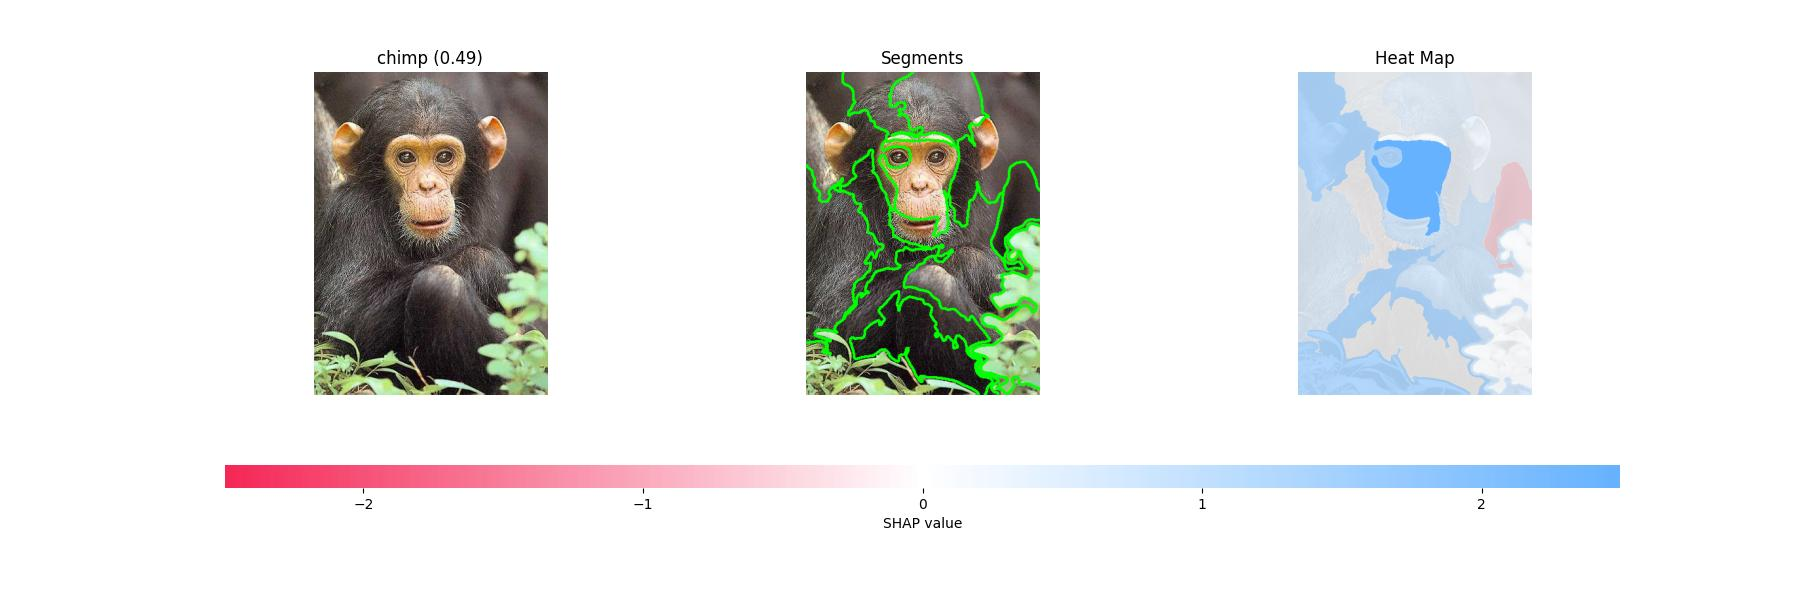

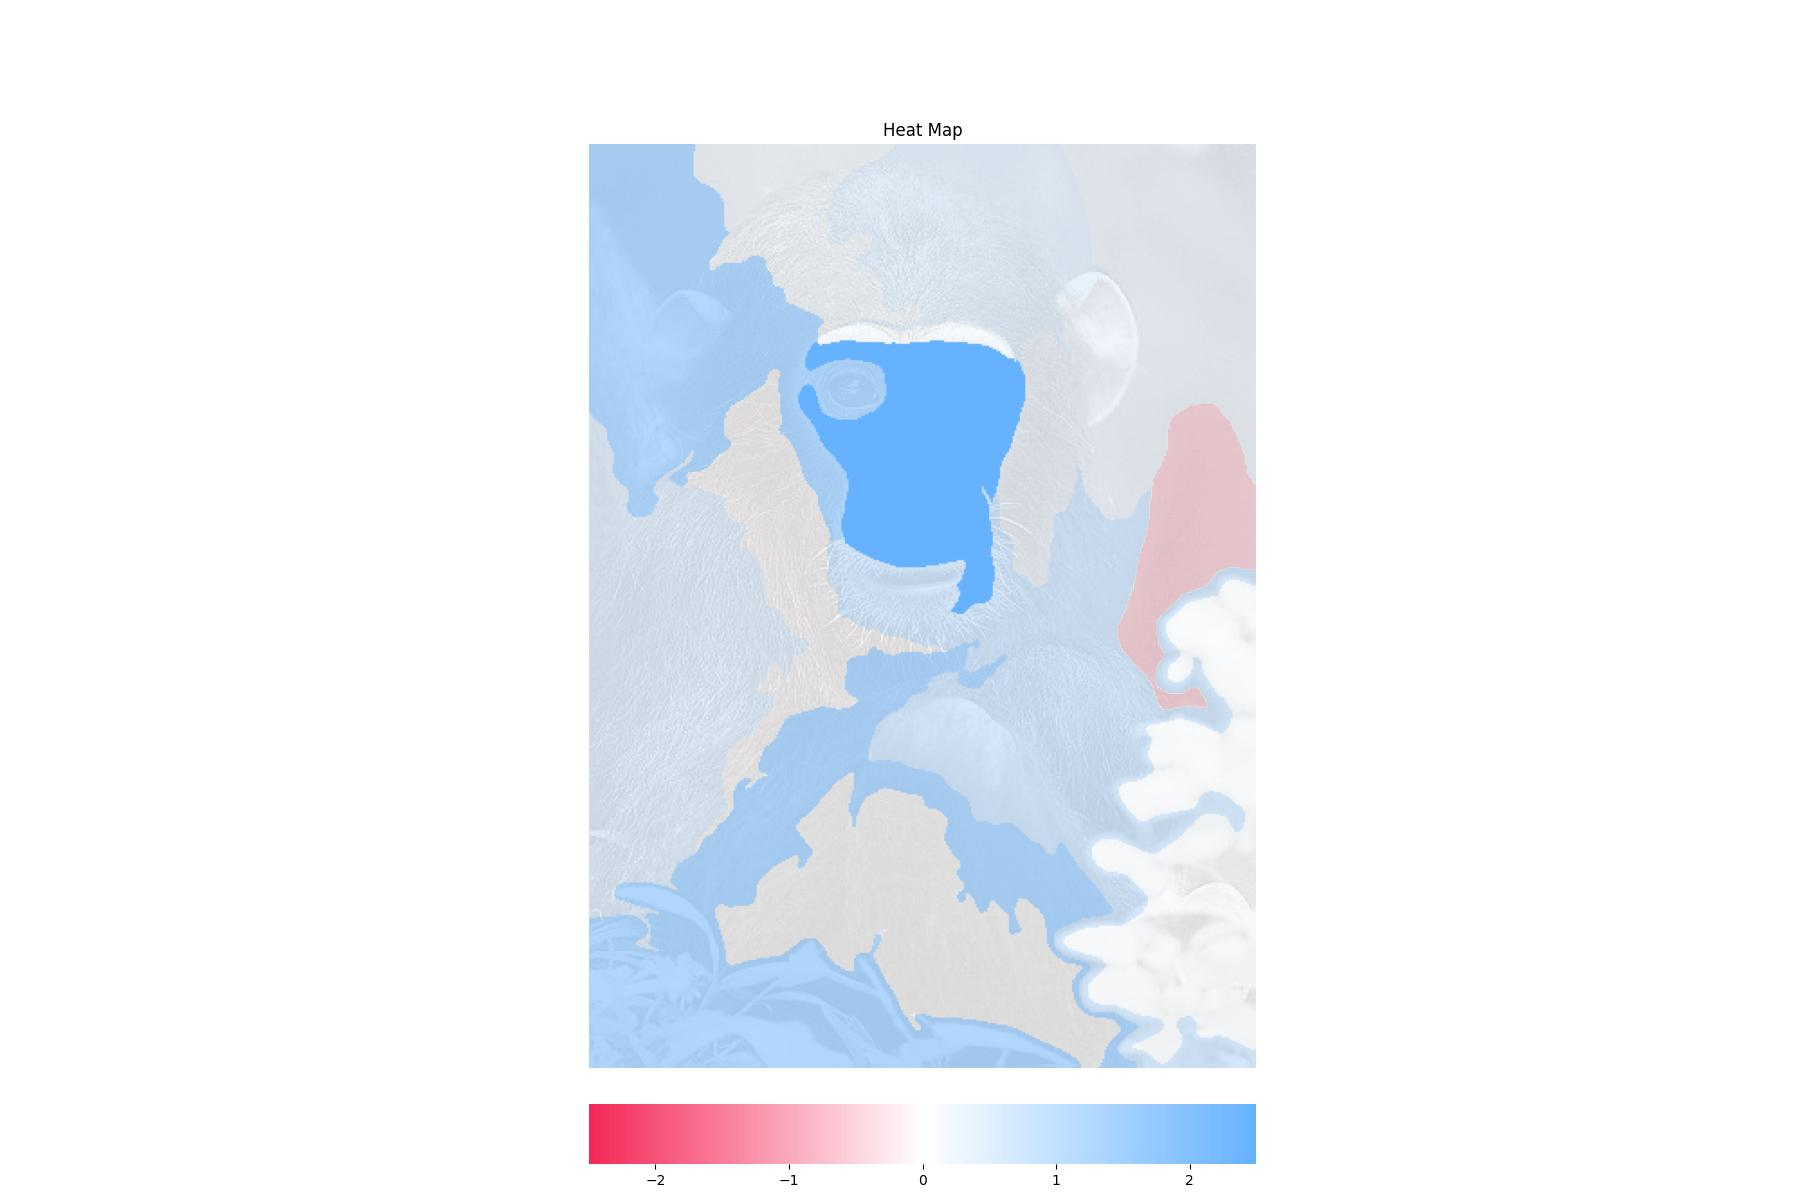

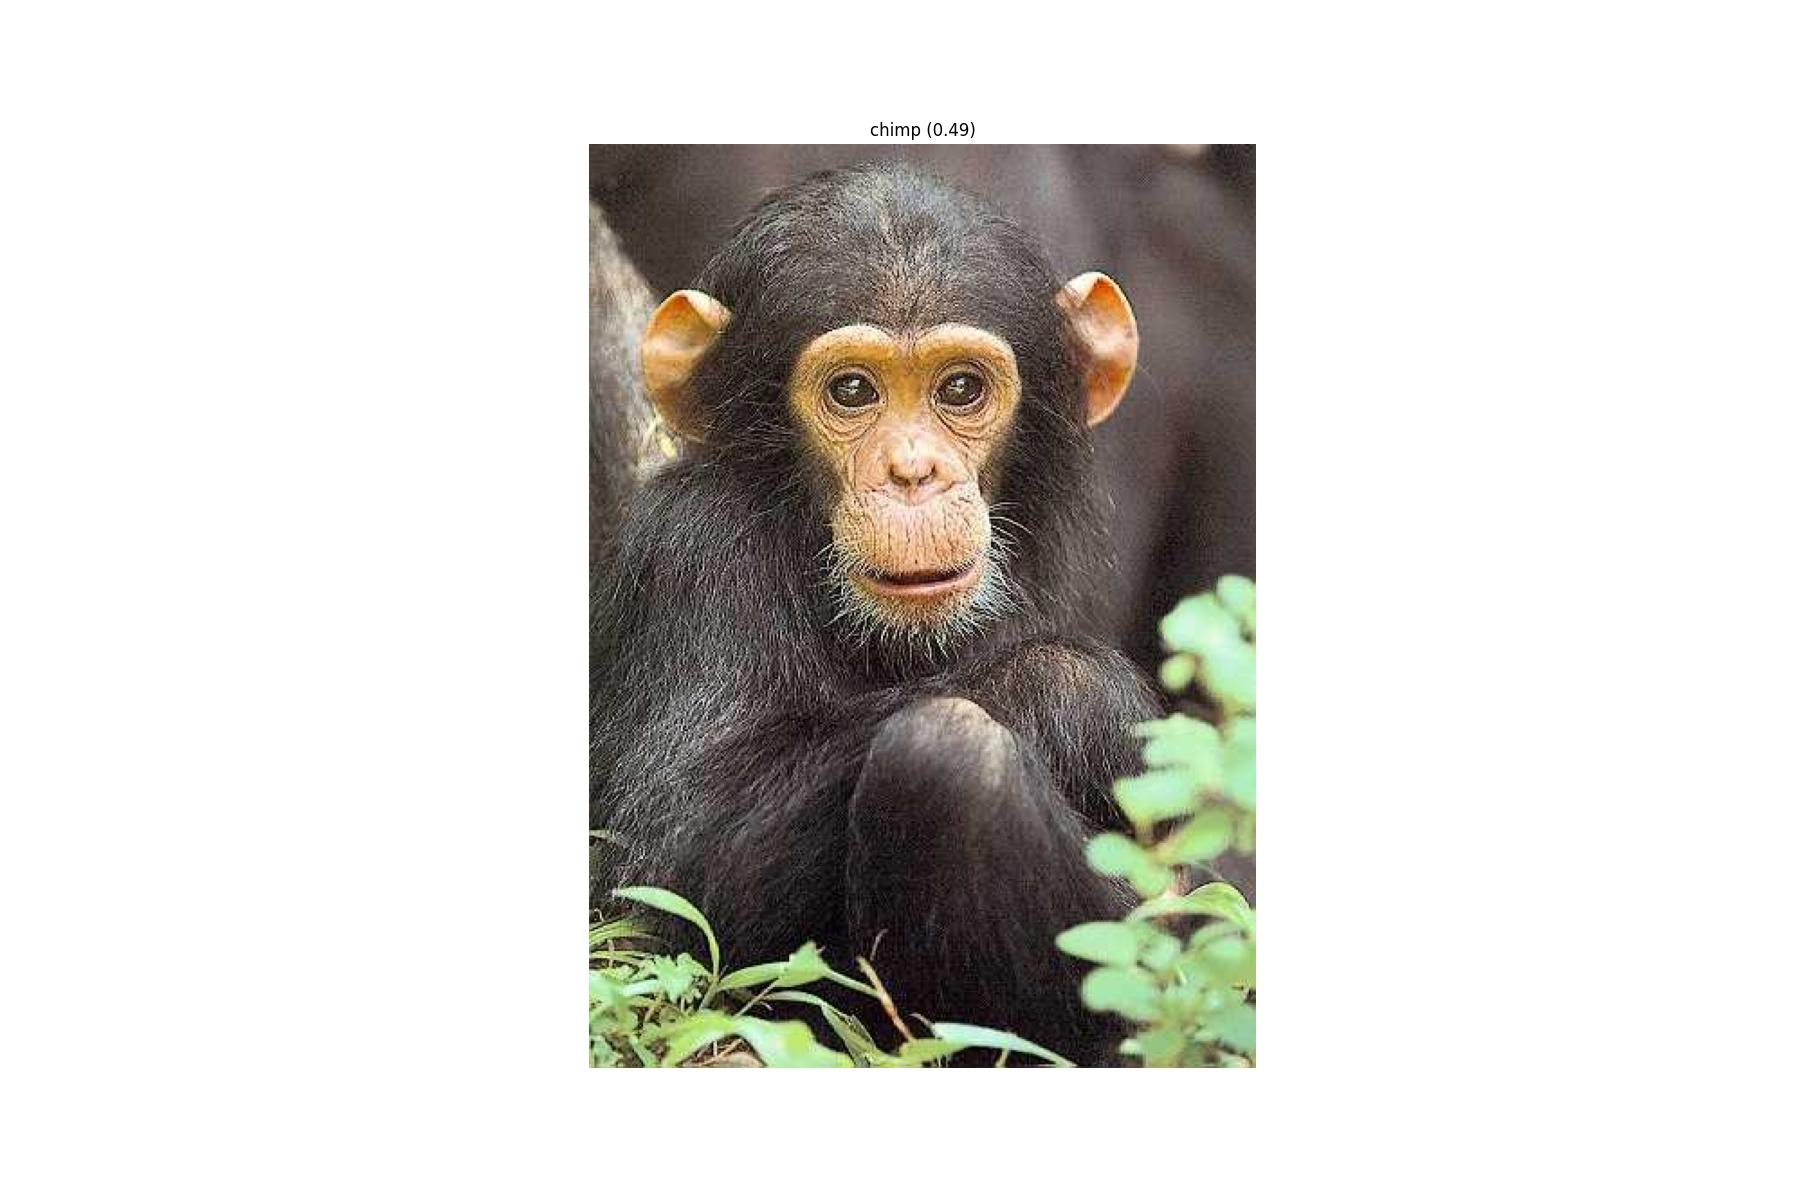

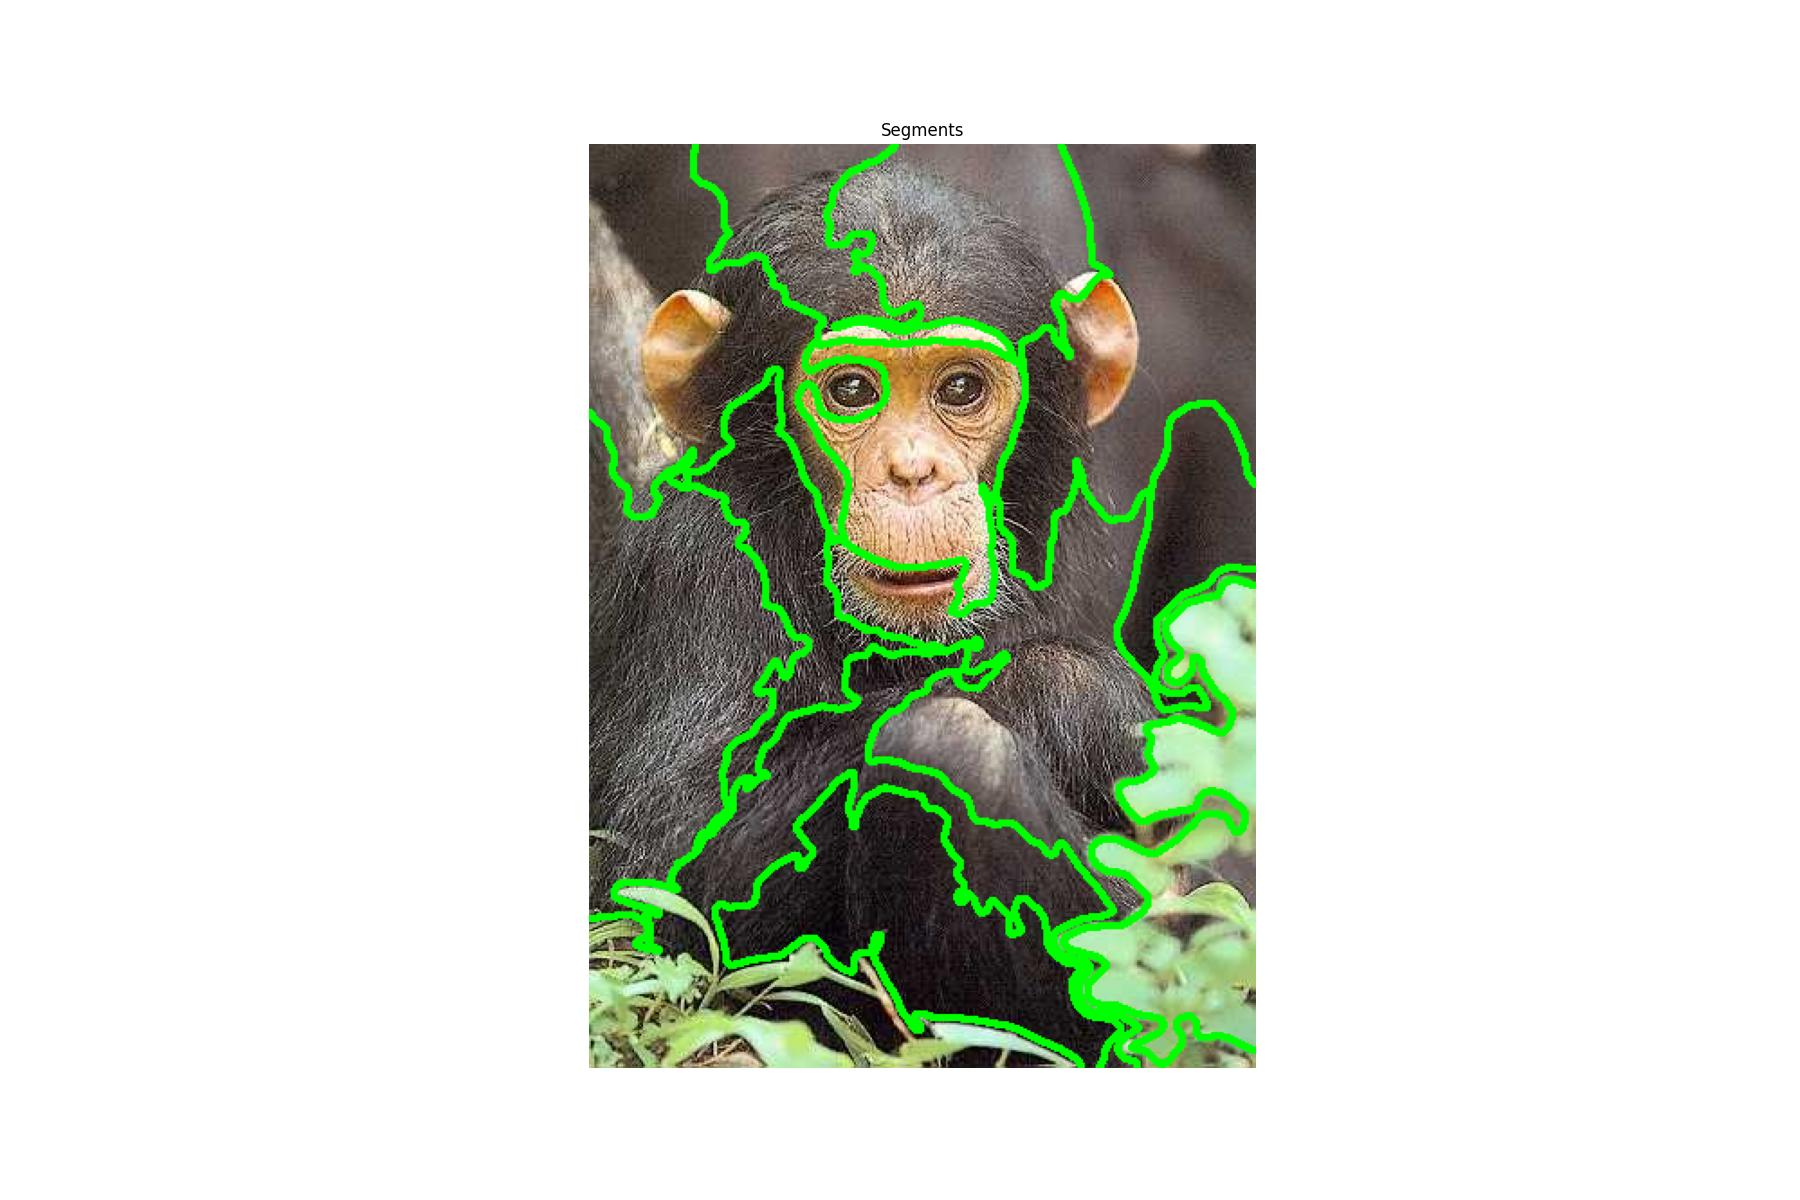

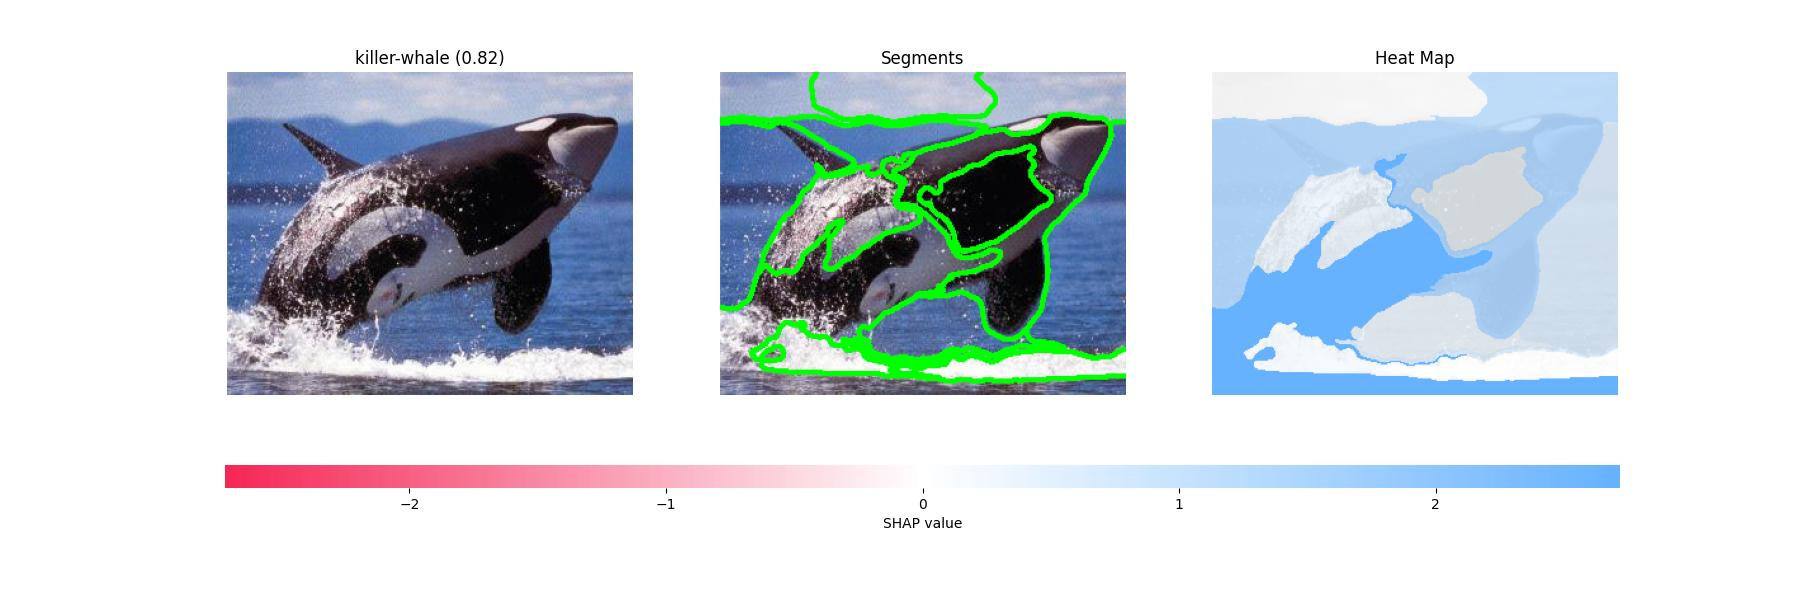

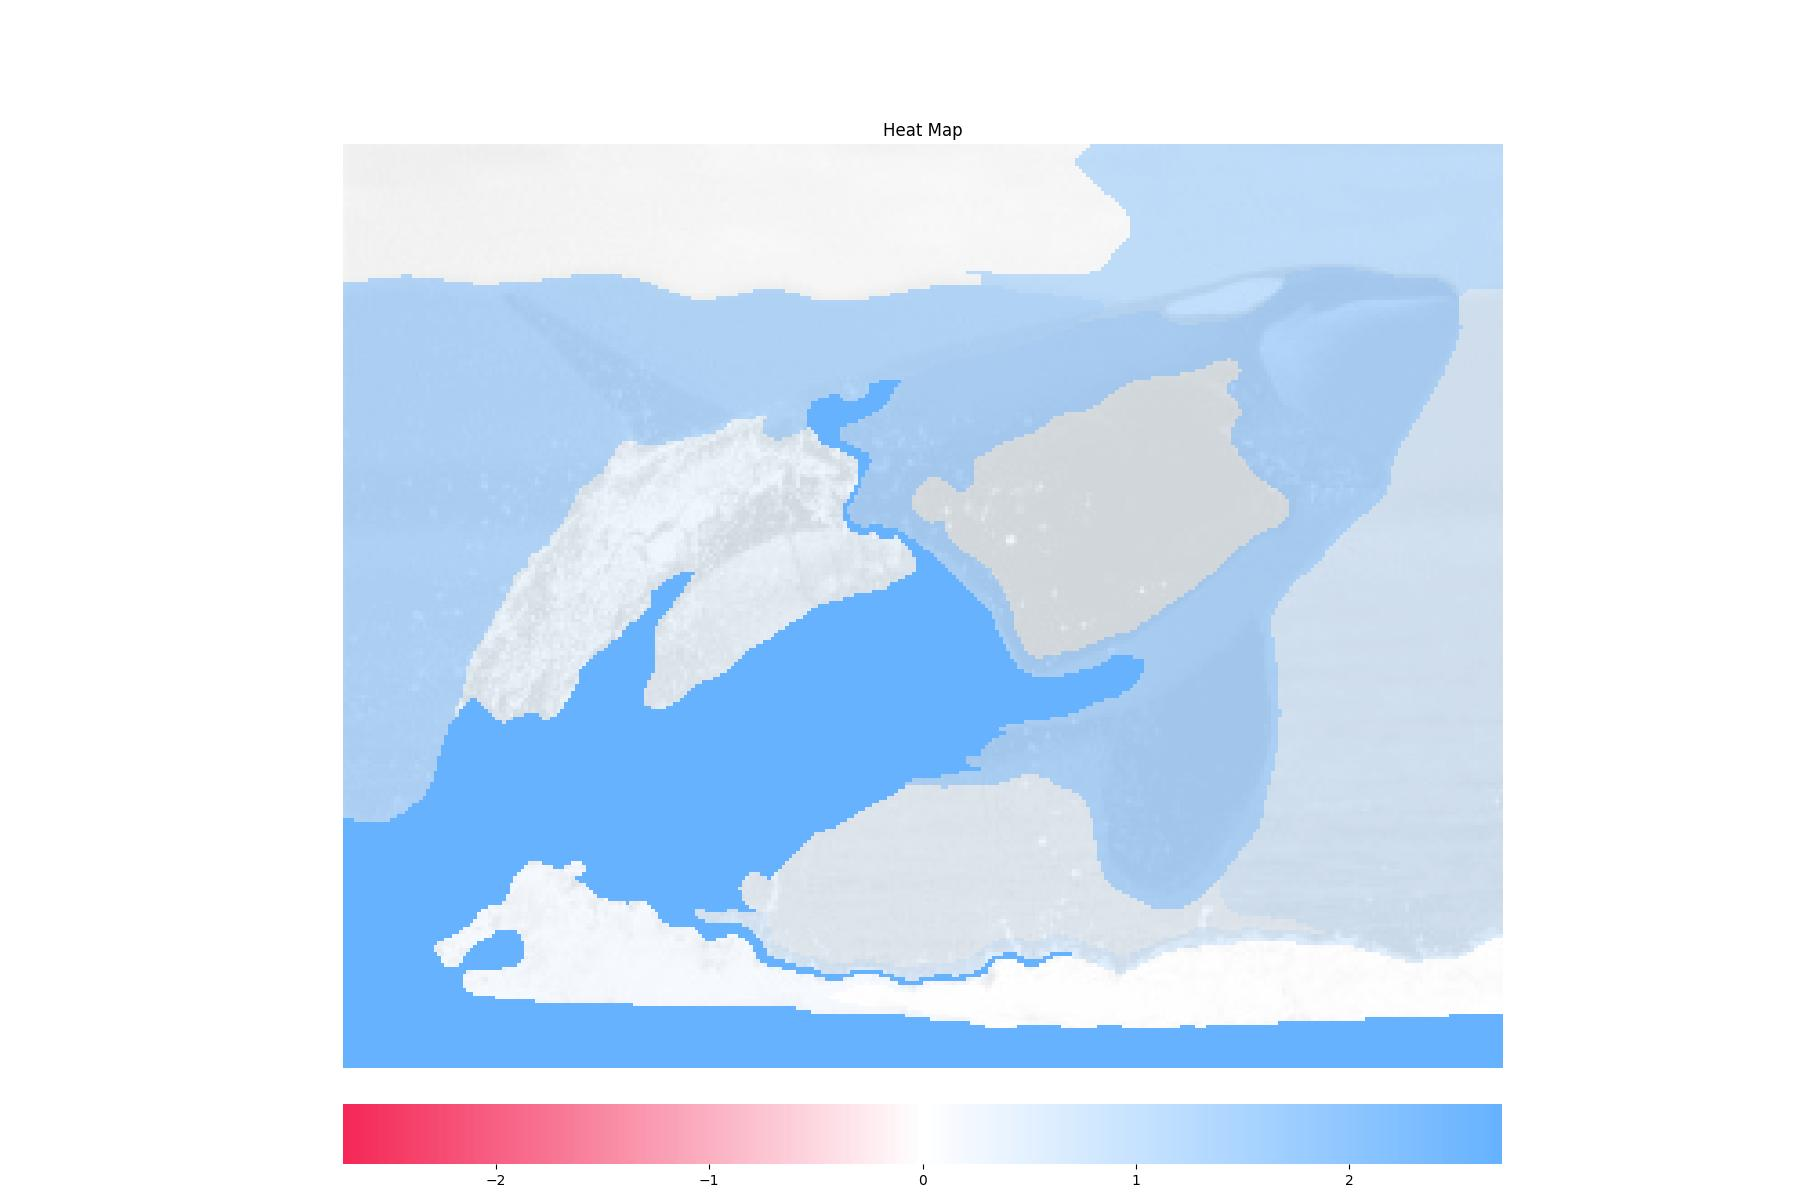

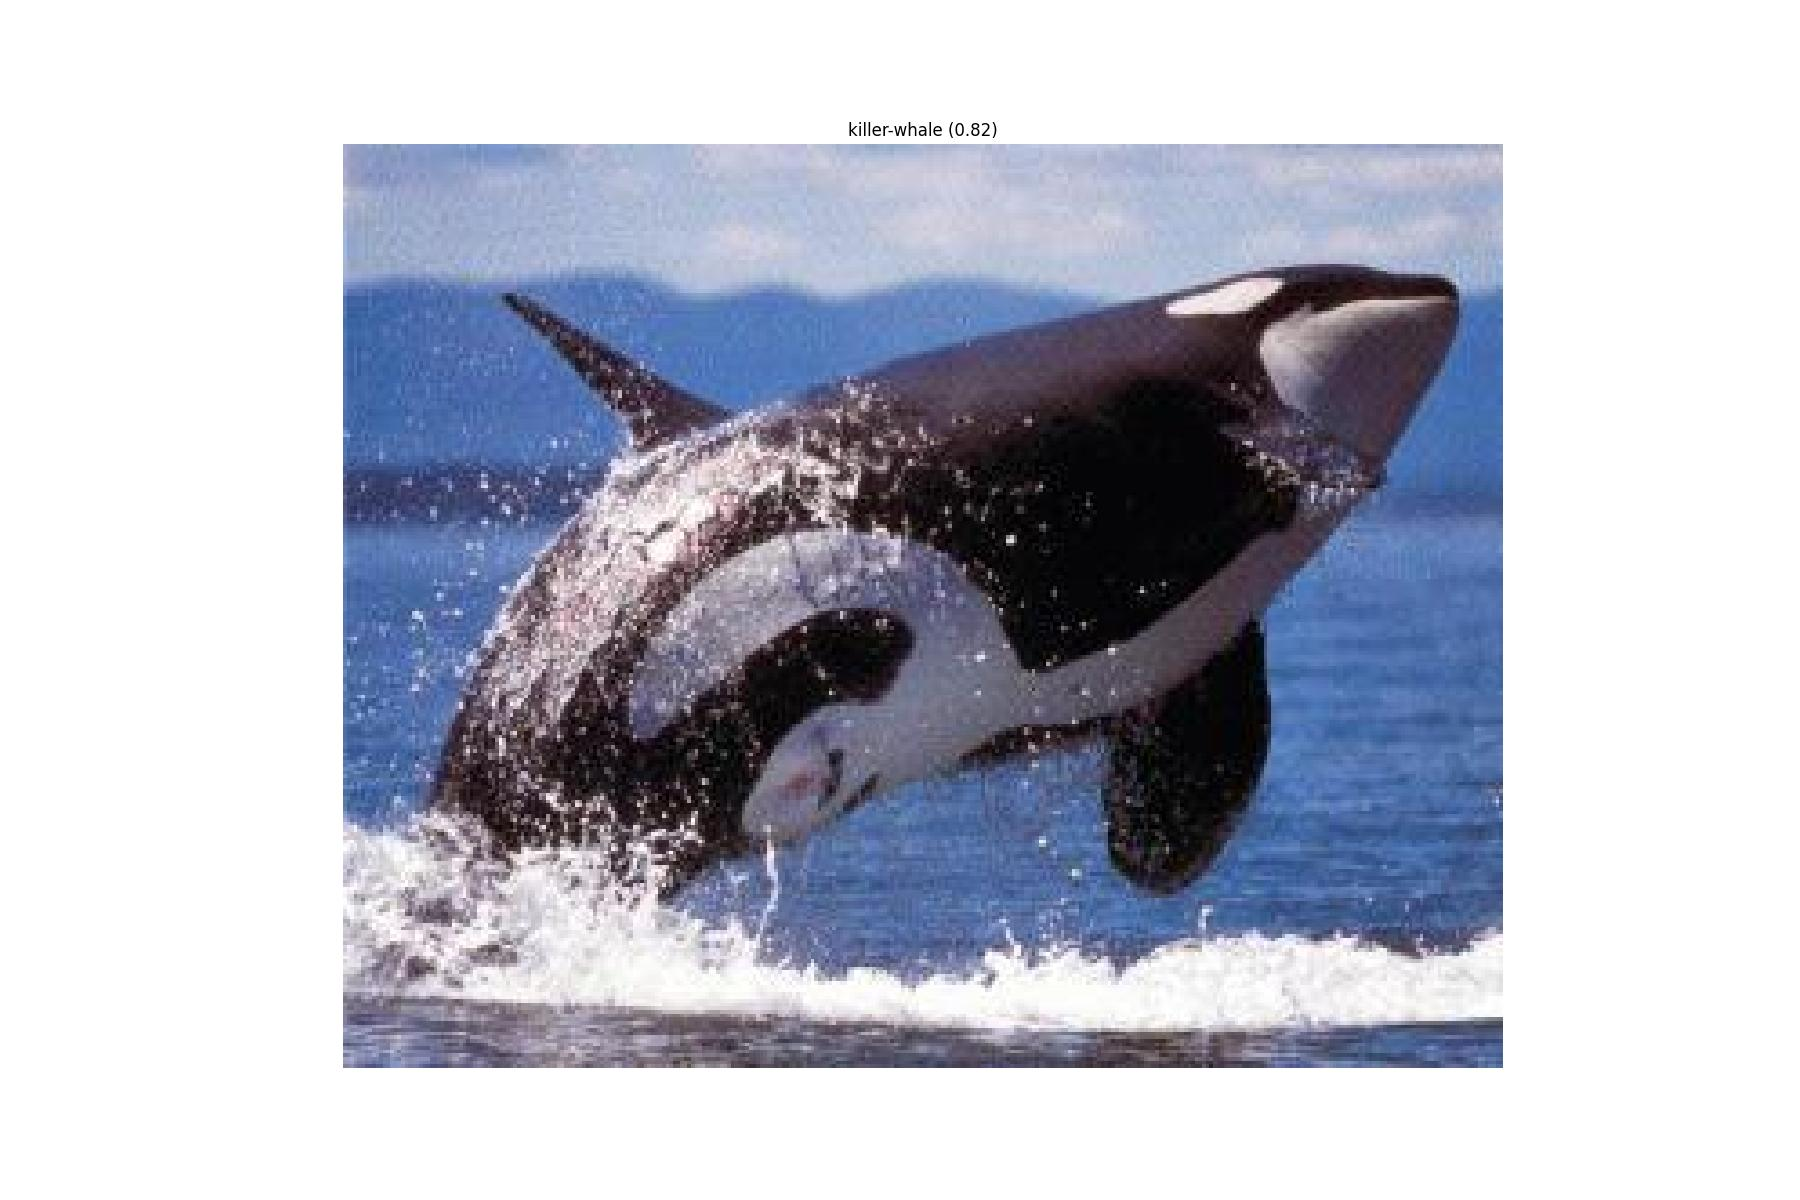

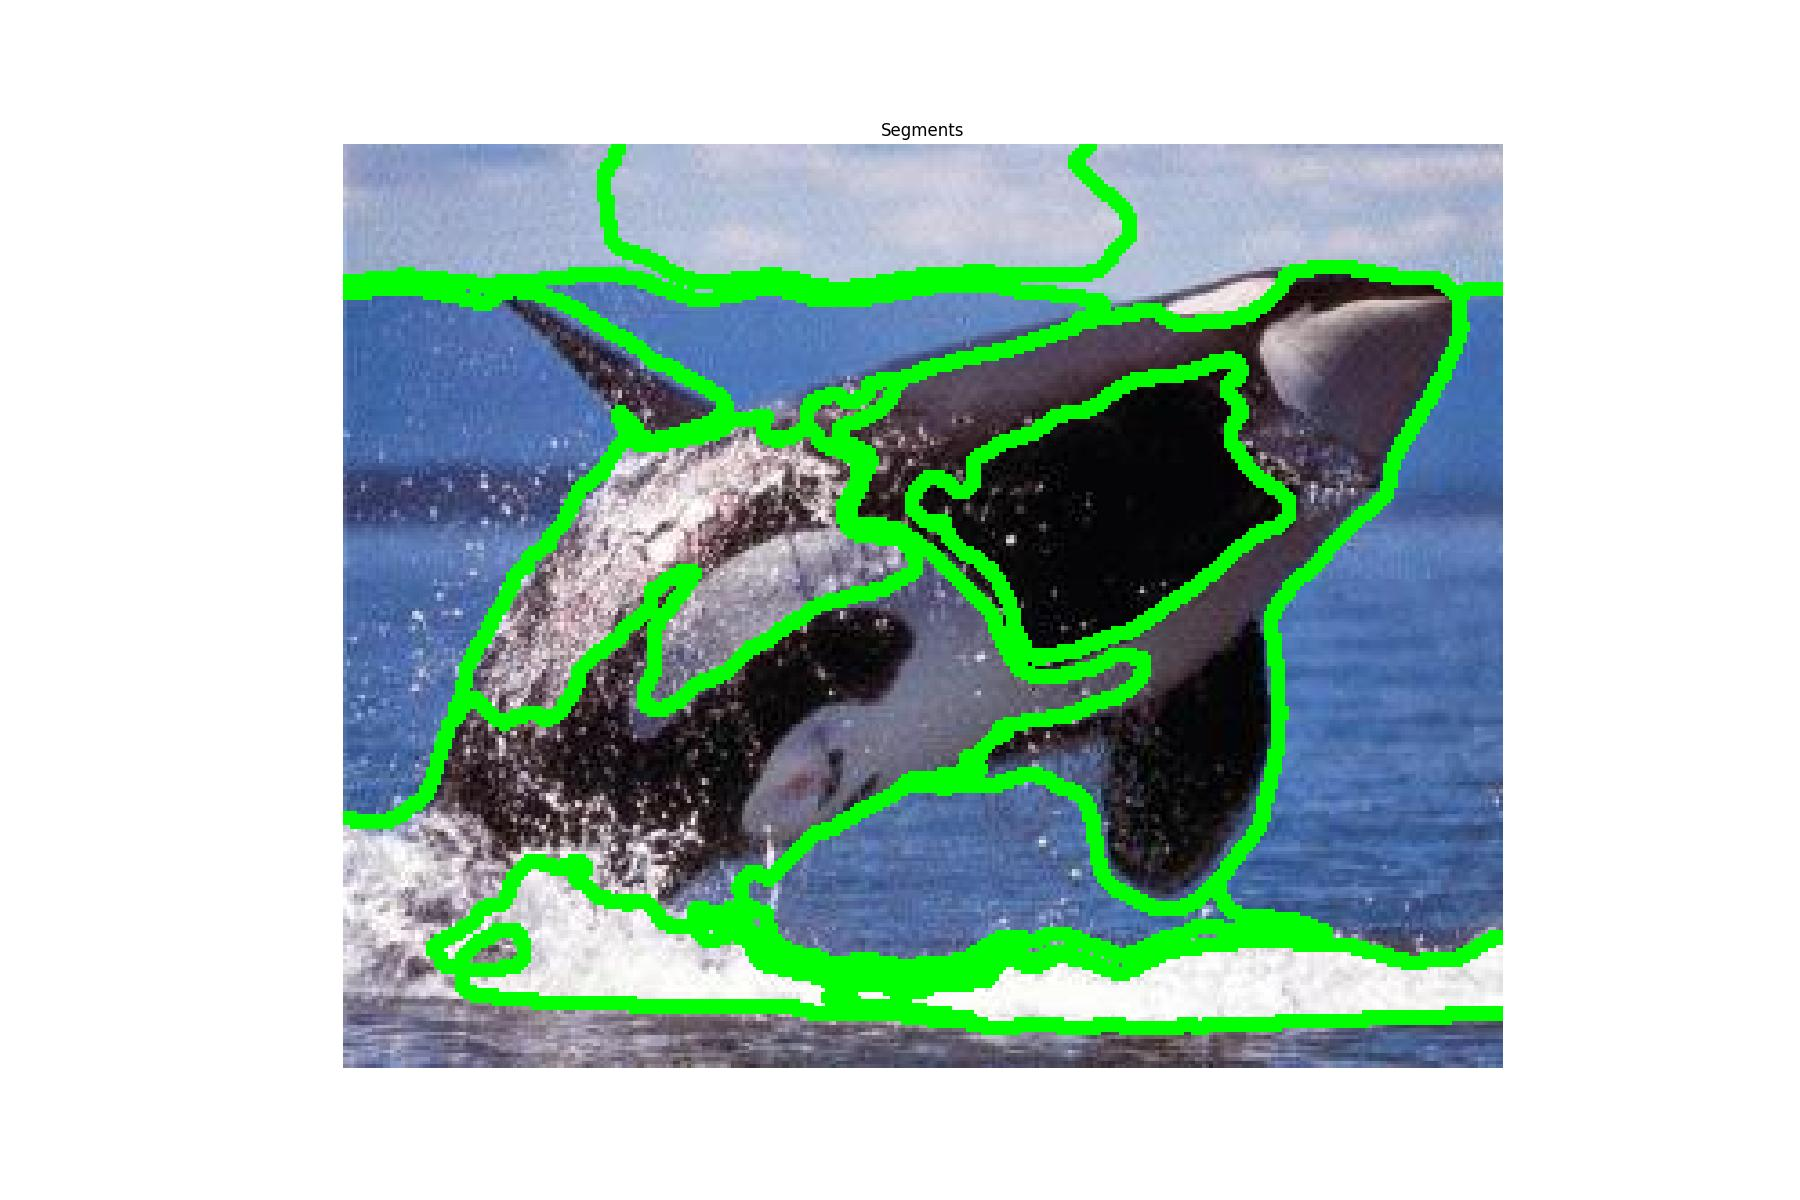

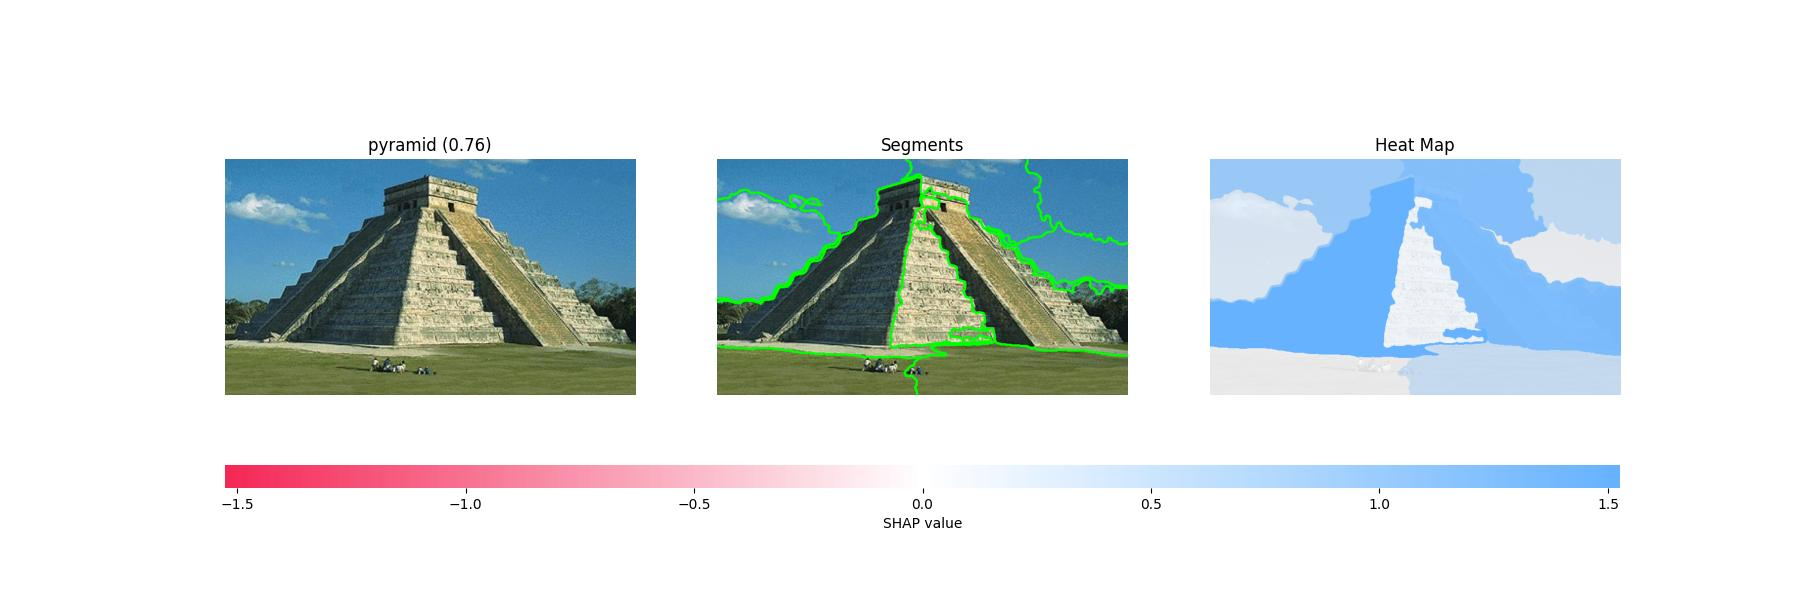

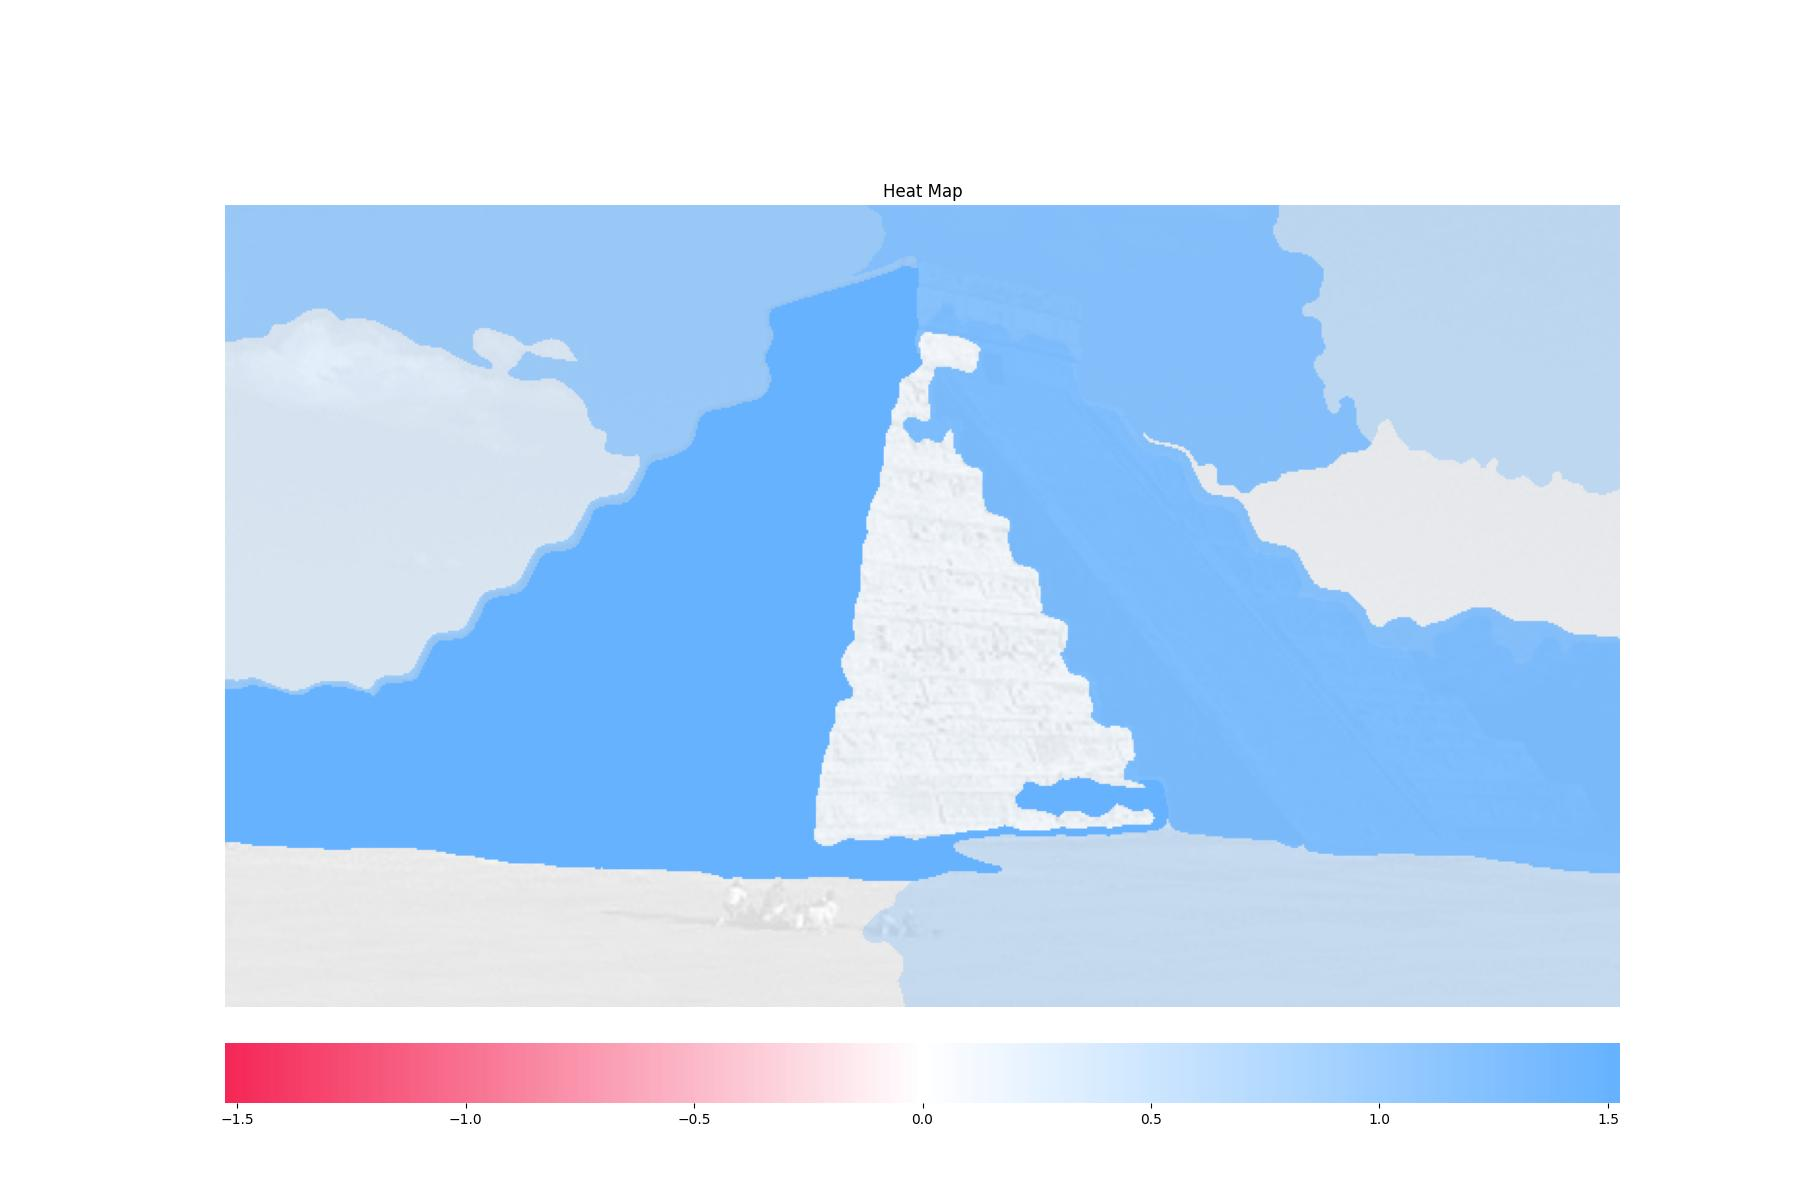

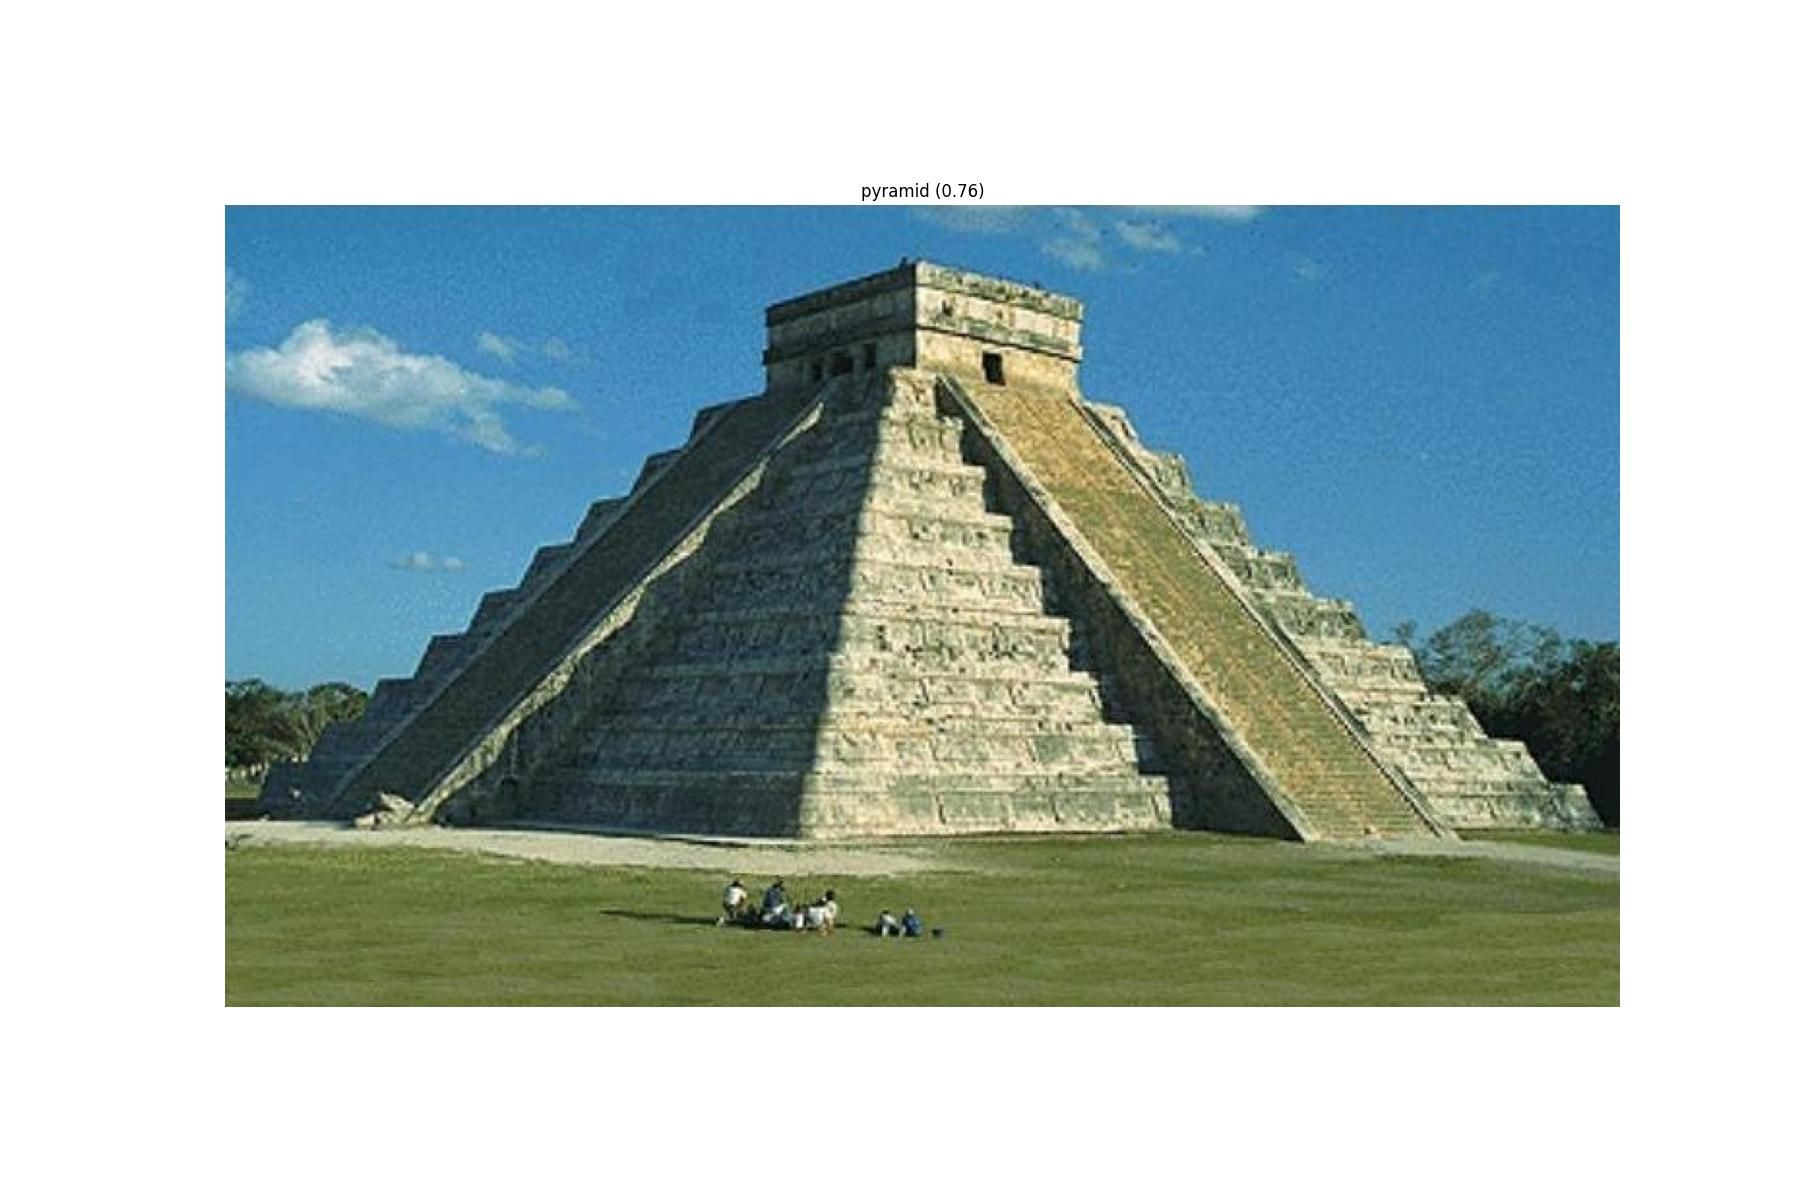

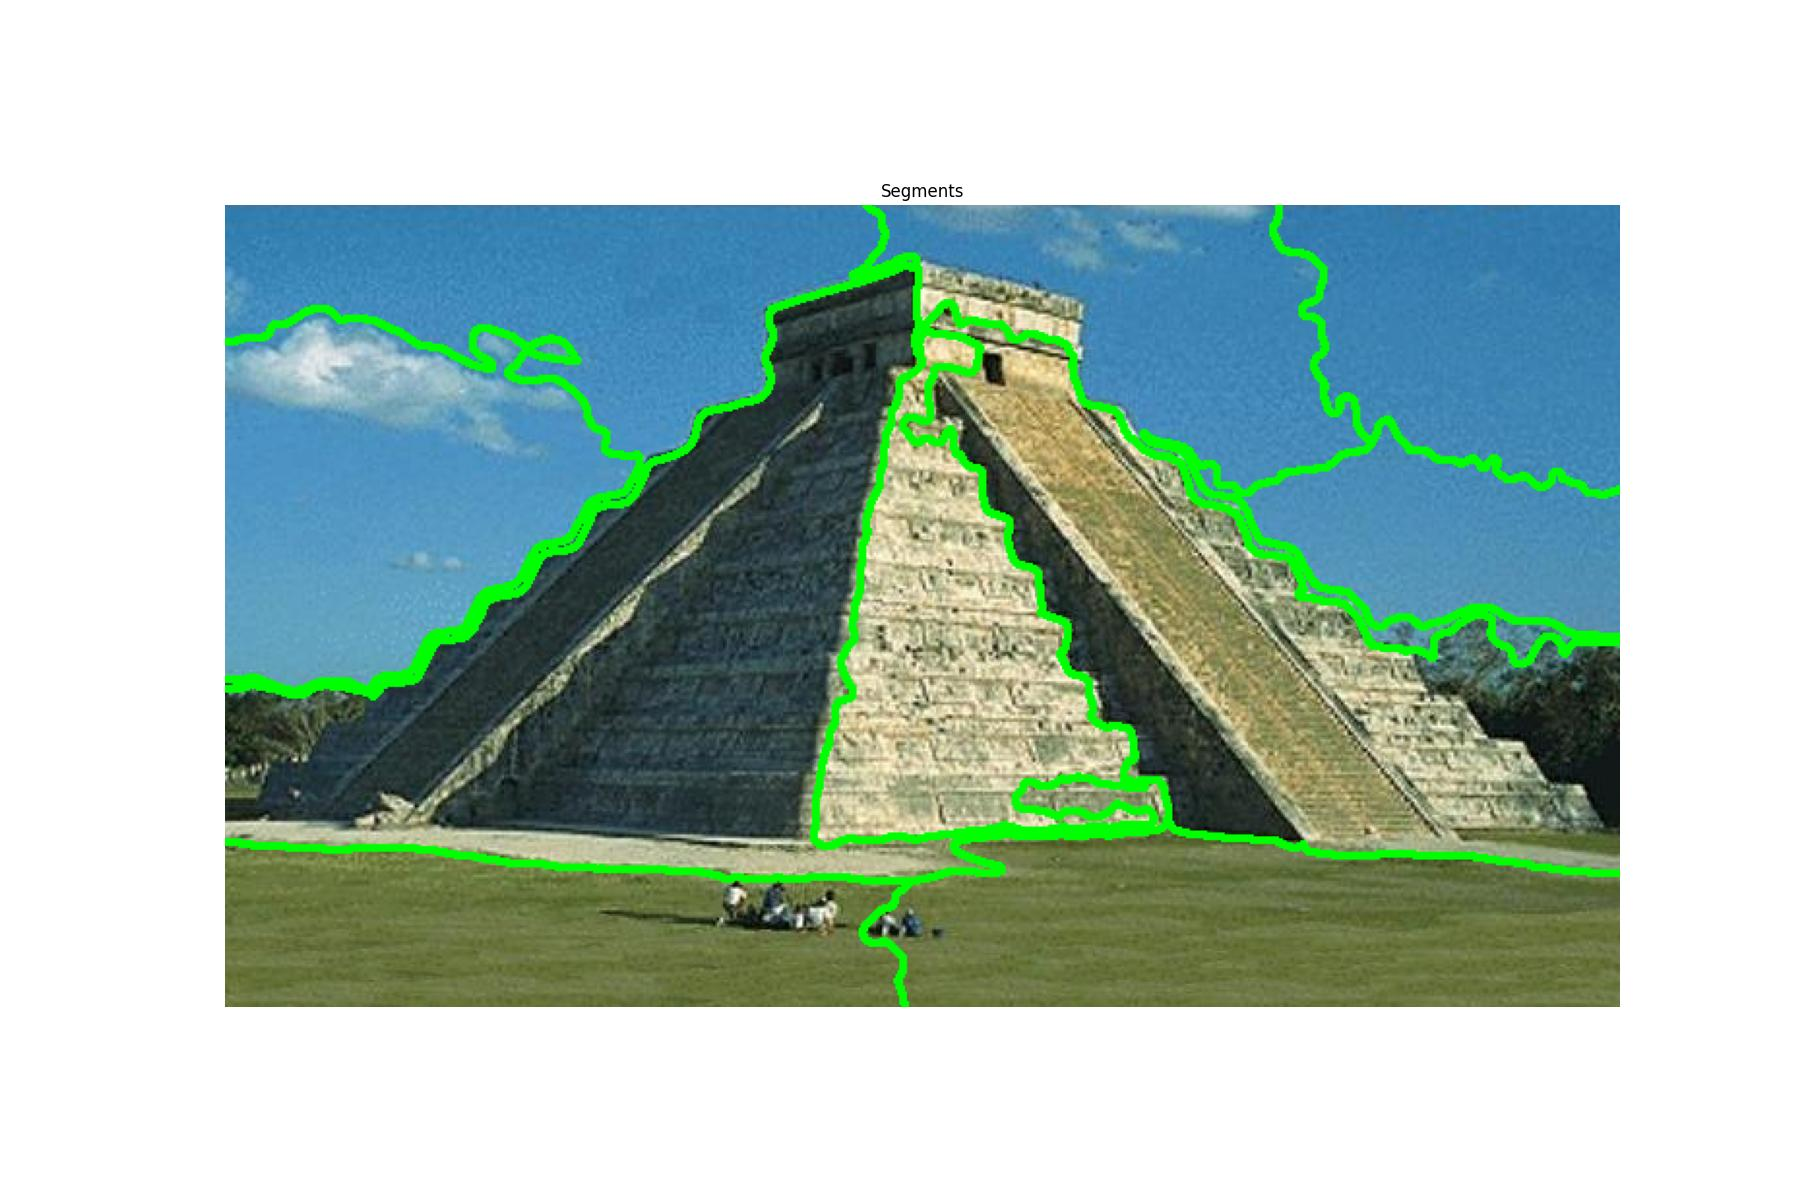

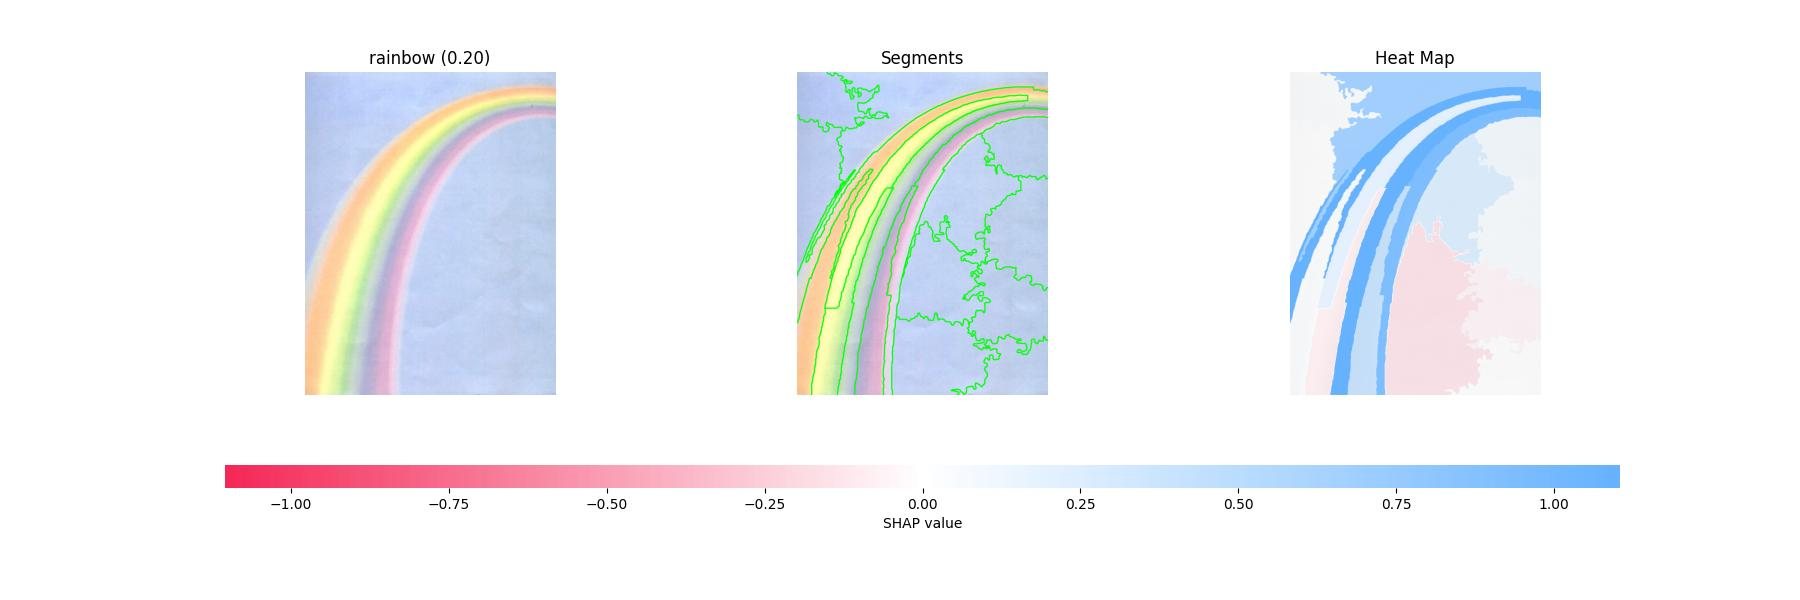

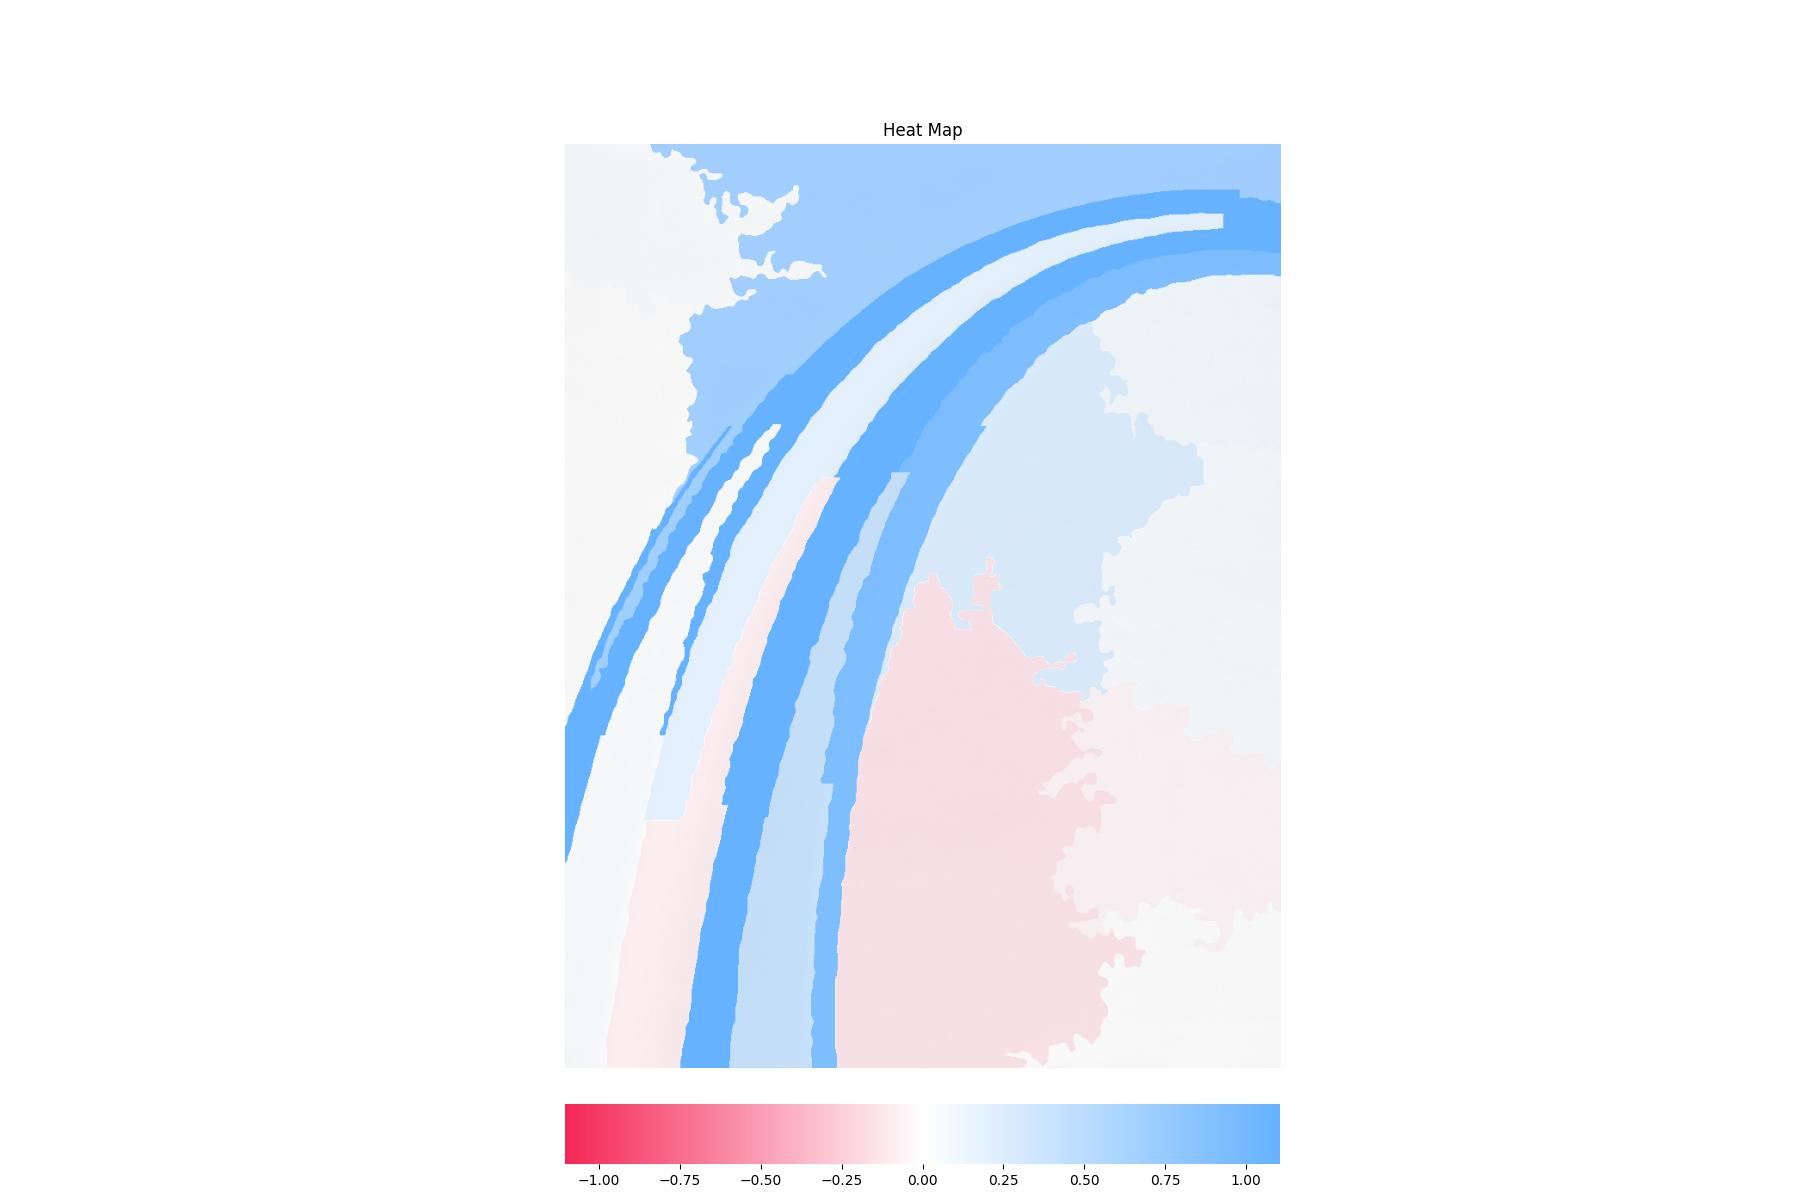

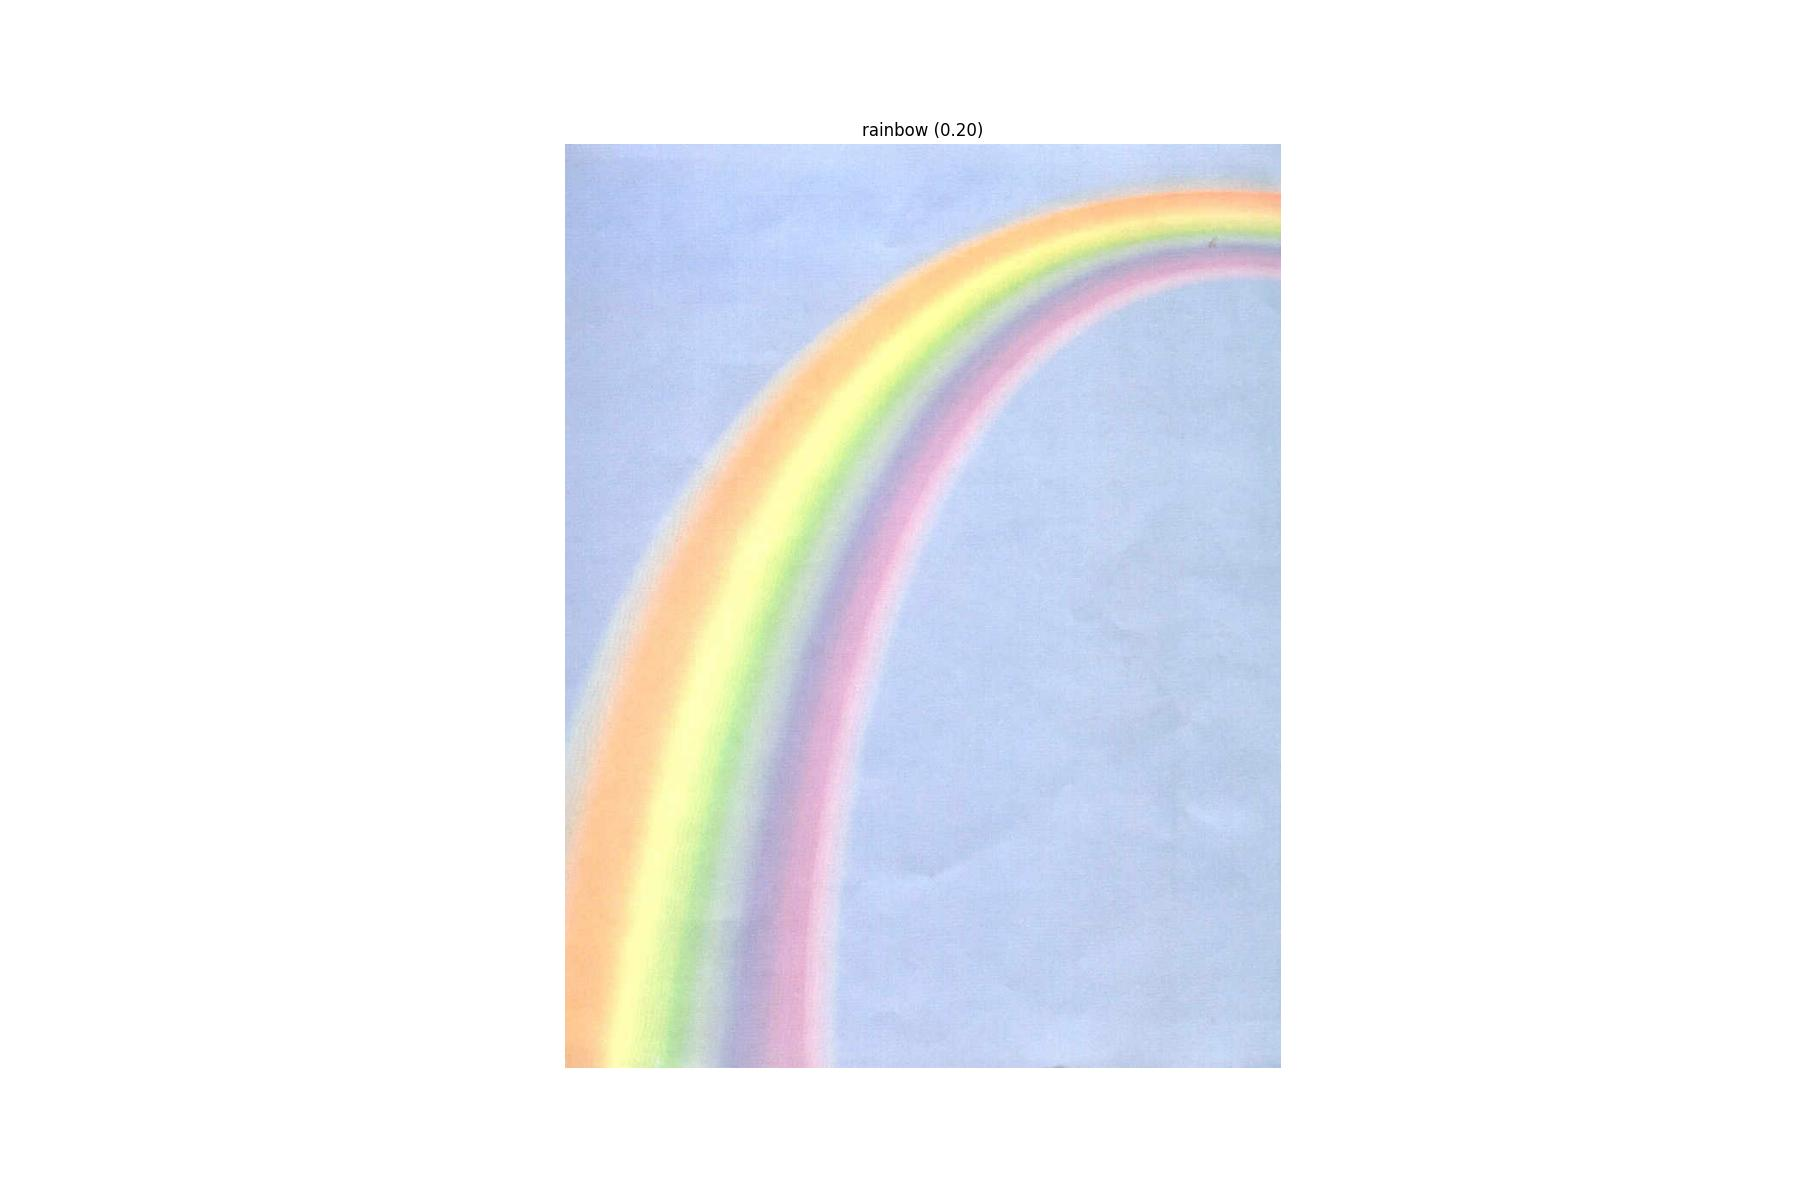

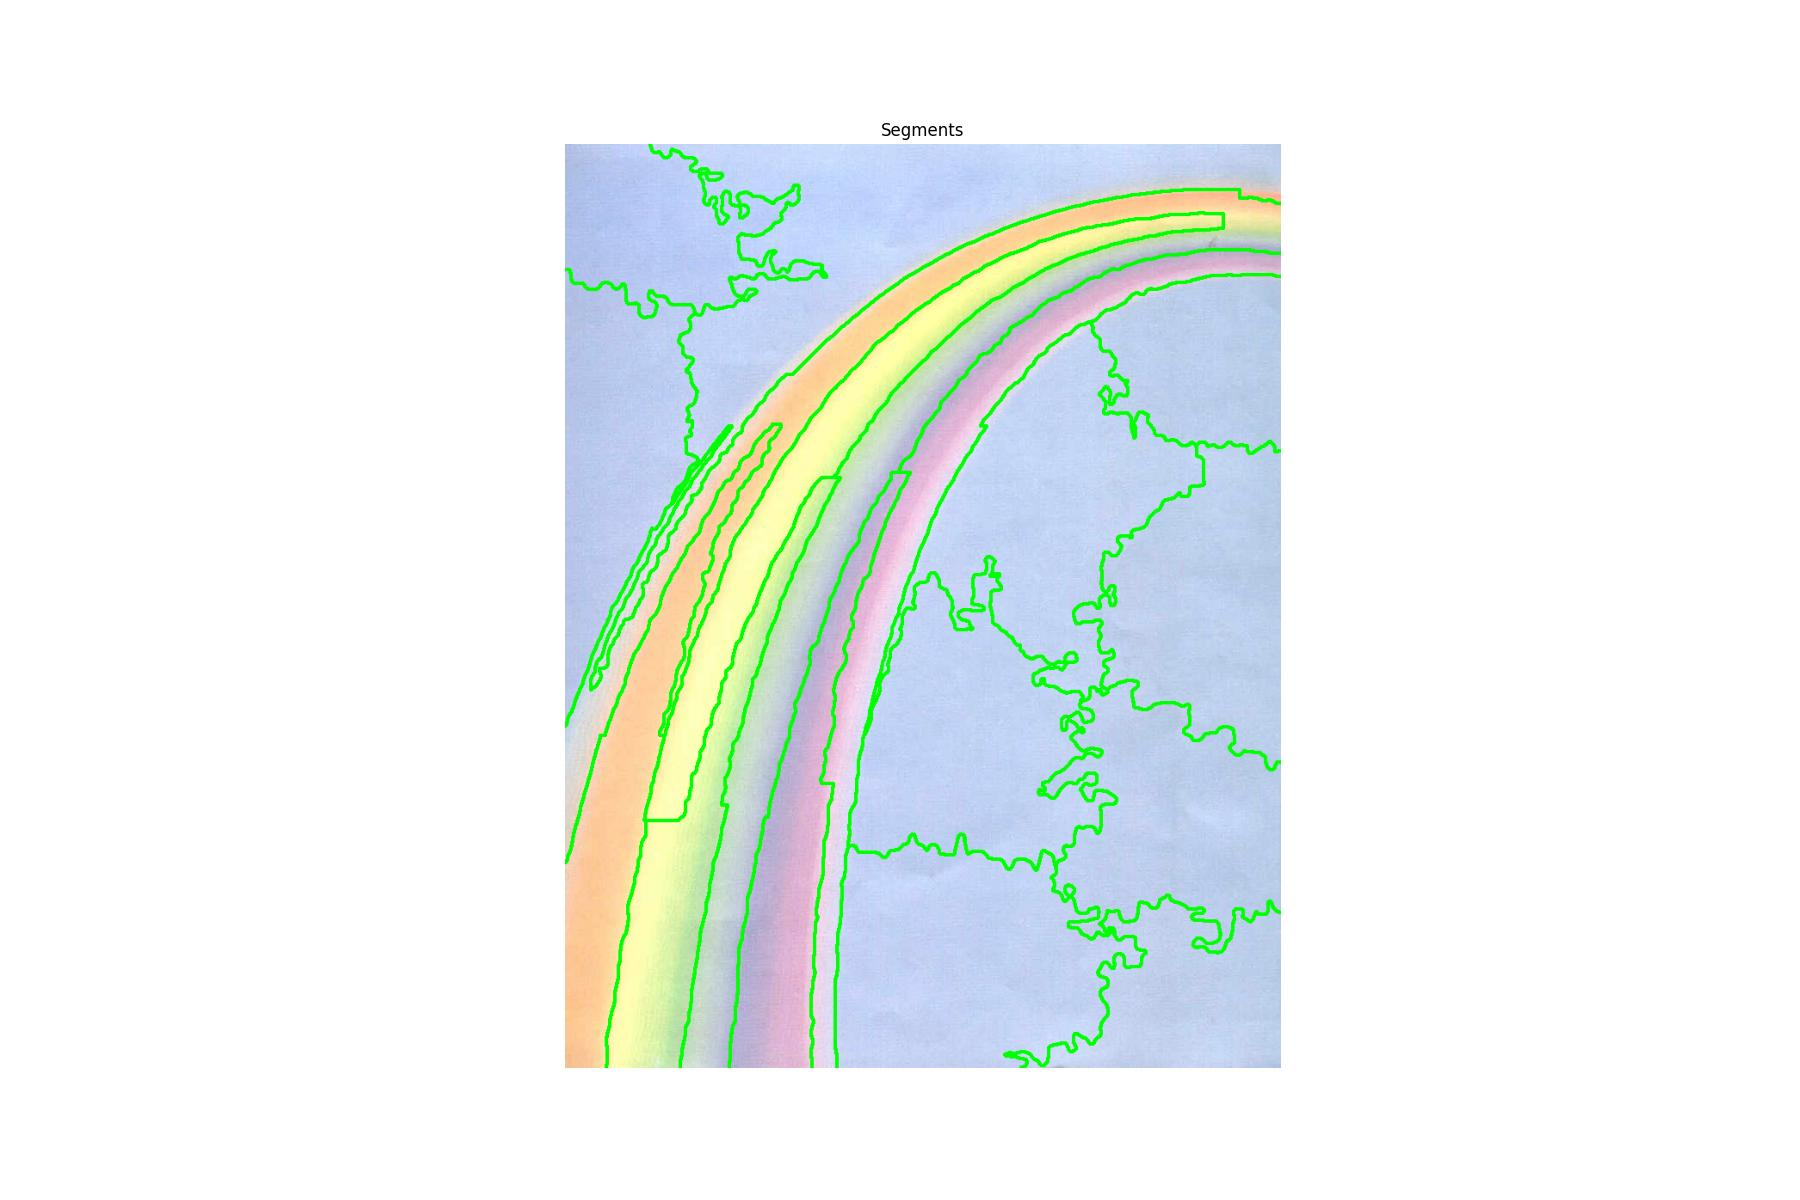

In [18]:
from IPython.display import Image

for img in result_images:
    display(Image(img))